## **Logistic Regression Model**

In [1]:
import numpy as np
import pandas as pd

import os

from matplotlib import pyplot as plt
from matplotlib.pyplot import specgram

import librosa
import librosa.display
import IPython.display as ipd
from IPython.display import Audio

from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler


import warnings
warnings.filterwarnings("ignore")

In [2]:
paths=[]
labels=[]

for dirname, _, filenames in os.walk('Emotions/input/'):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        label = filename[::-1].split('.')[0][::-1]
        name = dirname[::].split('/')[2]
        name_complete = name+'.'+label
        labels.append(name_complete.lower())

In [3]:
data = pd.DataFrame({'speech':paths,'label':labels})
data.sample(10)

,speech,label
6280,Emotions/input/Happy\03-02-03-01-01-01-12.wav,happy.wav
1855,Emotions/input/Angry\OAF_pass_angry.wav,angry.wav
7931,Emotions/input/Happy\OAF_pain_happy.wav,happy.wav
9268,Emotions/input/Neutral\1071_DFA_NEU_XX.wav,neutral.wav
10266,Emotions/input/Sad\03-02-04-01-01-02-13.wav,sad.wav
9412,Emotions/input/Neutral\1083_IEO_NEU_XX.wav,neutral.wav
2801,Emotions/input/Disgusted\1032_TIE_DIS_XX.wav,disgusted.wav
11415,Emotions/input/Sad\1072_MTI_SAD_XX.wav,sad.wav
11045,Emotions/input/Sad\1046_IEO_SAD_MD.wav,sad.wav
195,Emotions/input/Angry\03-02-05-01-01-01-04.wav,angry.wav


In [4]:
# Labelencoder para convertir las clases a etiquetas númericas
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()
# Encode labels in column 'label'.
data['label'] = data['label'].apply(lambda x: str(x).split('.wav')[0])
data['label']= label_encoder.fit_transform(data['label'])

In [5]:
data.head()

,speech,label
0,Emotions/input/Angry\03-01-05-01-01-01-01.wav,0
1,Emotions/input/Angry\03-01-05-01-01-01-02.wav,0
2,Emotions/input/Angry\03-01-05-01-01-01-03.wav,0
3,Emotions/input/Angry\03-01-05-01-01-01-04.wav,0
4,Emotions/input/Angry\03-01-05-01-01-01-05.wav,0


In [6]:
def waveplot(data,sr,emotion):
    plt.figure(figsize=(10,4))
    plt.title(emotion,size=20)
    librosa.display.waveshow(data,sr=sr)
    plt.show()
    
def spectogram(data,sr,emotion):
    x=librosa.stft(data)
    xdb=librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(11,4))
    librosa.display.specshow(xdb,sr=sr,x_axis='time',y_axis='hz')
    plt.colorbar()
    
def ana_emotion(emotion:str, df:pd.DataFrame):
    path=np.array(df['speech'][df['label']==emotion])[0]
    data,sampling_rate=librosa.load(path)
    waveplot(data,sampling_rate,emotion)
    spectogram(data,sampling_rate,emotion)
    Audio(path)

In [7]:
# Clases de emociones en el datset
data['label'].unique().tolist()

[0, 1, 2, 3, 4, 5, 6]

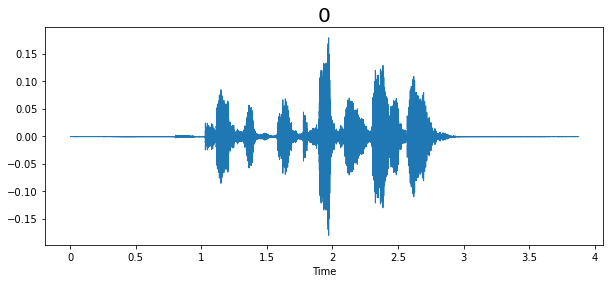

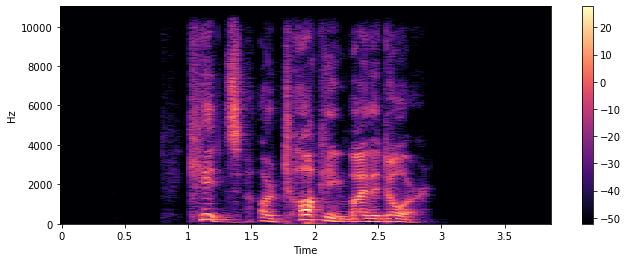

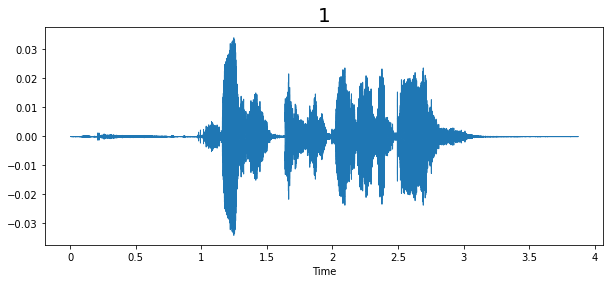

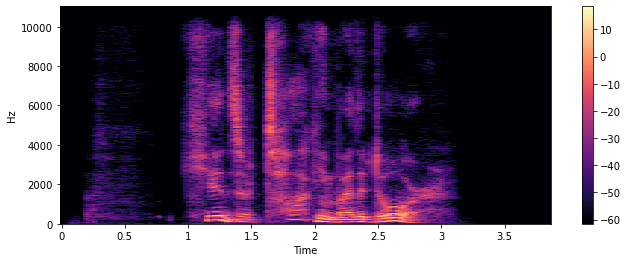

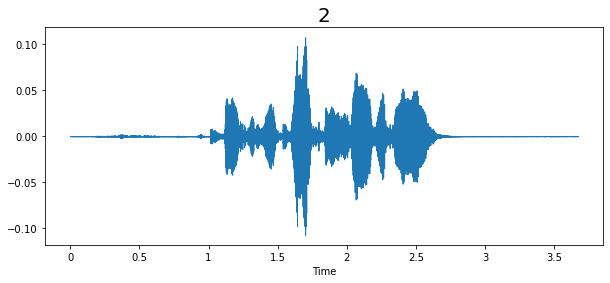

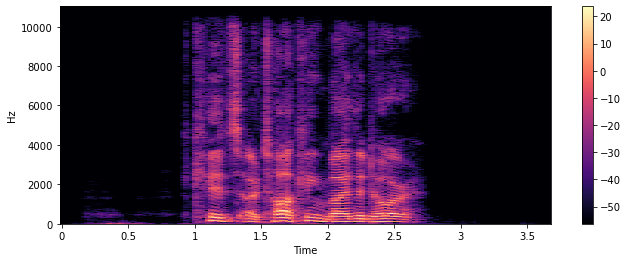

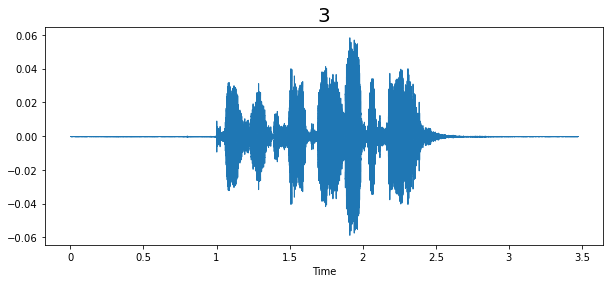

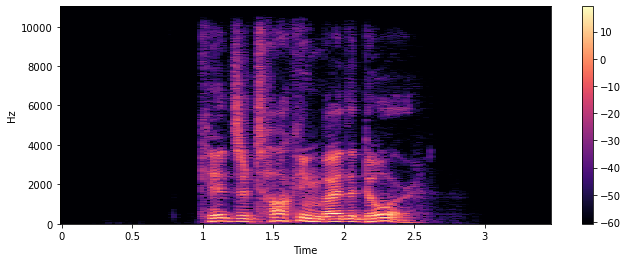

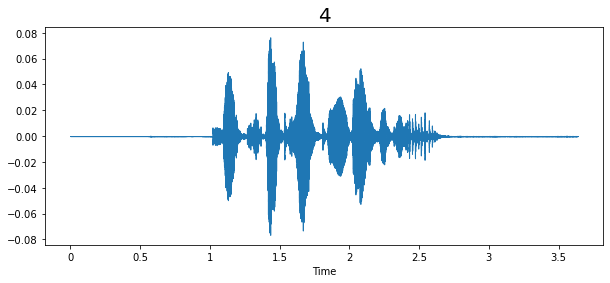

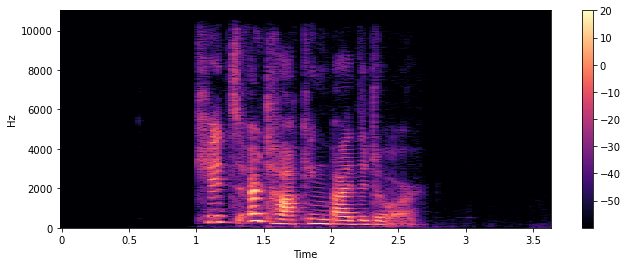

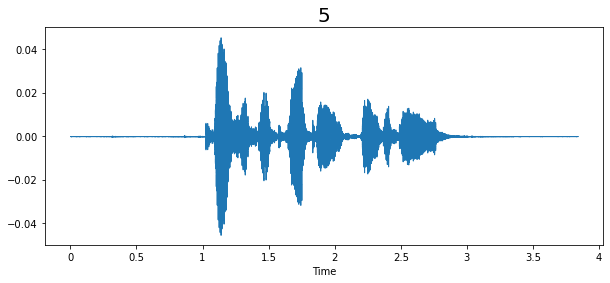

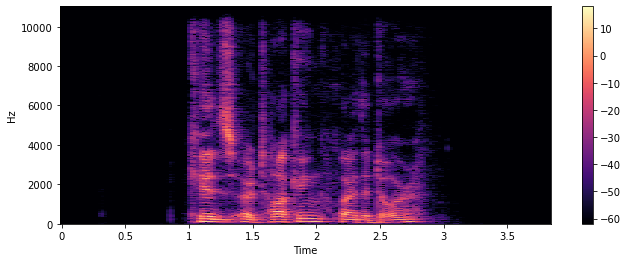

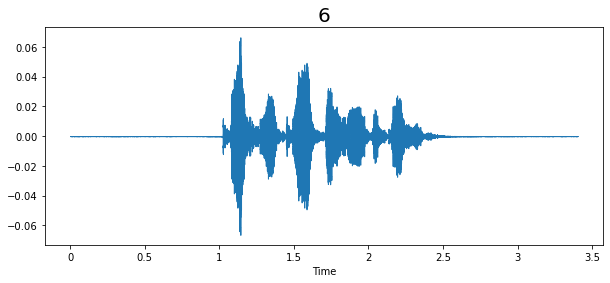

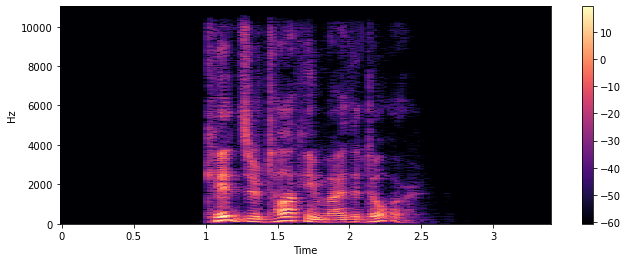

In [8]:
for i in data['label'].unique().tolist(): # ver uno de cada sentimiento
    ana_emotion(i,data)

In [9]:
# Coeficientes Septrales - Transformación del audio en una serie de parametros que representan de forma compacta el sonido
def MFCC(filename):
    y, sr = librosa.load(filename,duration=3,offset=0.5)
    return np.mean(librosa.feature.mfcc(y=y,sr=sr,n_mfcc=40).T,axis=0)

mfcc= data['speech'].apply(lambda x:MFCC(x))

In [10]:
np.save('Datasets/mfcc.npy', mfcc)

In [13]:
print(f'Cantidad de Registros de Audio: {mfcc.shape}')

Cantidad de Registros de Audio: (12798,)


In [14]:
import numpy as np
X = np.asarray(mfcc.to_list())
y = np.asarray(data['label'])


In [15]:
X

array([[-4.9236911e+02,  5.6363400e+01, -9.5842419e+00, ...,
        -3.0204347e-01, -4.6737876e+00, -1.5017204e+00],
       [-5.2797430e+02,  5.4694382e+01, -1.4746857e+01, ...,
         1.8938642e+00,  4.9922979e-01,  1.0369350e+00],
       [-5.5716321e+02,  7.9169151e+01, -1.0876601e+00, ...,
        -2.7364600e+00, -6.0165200e+00, -1.7894462e+00],
       ...,
       [-3.4590451e+02,  6.2633904e+01,  2.1816177e+00, ...,
         3.1764922e+00, -1.4632556e-01,  2.7278659e+00],
       [-3.3467050e+02,  8.0249825e+01, -3.2716793e+01, ...,
         6.3607258e-01,  1.6670487e+00,  3.2698379e+00],
       [-3.7612756e+02,  6.3290413e+01, -6.5078440e+00, ...,
         5.6975141e+00,  3.1801860e+00,  2.4653611e+00]], dtype=float32)

In [16]:
y

array([0, 0, 0, ..., 6, 6, 6])

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [18]:
#Estandarizar
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [19]:
print(f'Dimensiones mfcc:{X.shape}')
print(f'Dimensiones label:{y.shape}')

Dimensiones mfcc:(12798, 40)
Dimensiones label:(12798,)


In [20]:
# Grid search cross validation
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
grid={"C":np.logspace(-3,3,7), "penalty":['l1','l2','none']}# l1 lasso l2 ridge and none

logreg=LogisticRegression()
logreg_cv=GridSearchCV(logreg,grid,cv=10)
logreg_cv.fit(X_train,y_train)

print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 10.0, 'penalty': 'l2'}
accuracy : 0.47959533980113916


In [21]:
logistic_model_LR = LogisticRegression(C=10,penalty="l2",solver="liblinear")
logistic_model_LR.fit(X_train,y_train)
print("score",logistic_model_LR.score(X_test,y_test))

score 0.44609375


In [22]:
metrics = ['accuracy']
cv_results_LR = cross_validate(logistic_model_LR, X_train, y_train, scoring=metrics, cv = 10)

In [23]:
'''
Resultados obtenidos aplicando validación cruzada(cross-validation) al modelo
LogisticRegression
'''
cv_results_LR

{'fit_time': array([0.64775348, 0.66999578, 0.57096386, 0.56302667, 0.53699422,
        0.60717535, 0.69602013, 0.64844012, 0.56522536, 0.64444304]),
 'score_time': array([0.00099707, 0.00102663, 0.00099802, 0.00099993, 0.00097322,
        0.00199771, 0.        , 0.00099897, 0.00100207, 0.00097227]),
 'test_accuracy': array([0.47135417, 0.47395833, 0.48350694, 0.46354167, 0.45659722,
        0.49305556, 0.49826389, 0.4765625 , 0.46741964, 0.45612511])}

In [24]:
#Predecir sobre el train y sobre el test
y_pred_train = logistic_model_LR.predict(X_train)
y_pred_test = logistic_model_LR.predict(X_test)

In [25]:
#Calcule el accuracy. Graficar la matriz de confusión.
#Calcule el accuracy. 

from sklearn.metrics import accuracy_score
accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)

print(f'Acc en el conjunto de entrenamiento: {accuracy_train}')
print(f'Acc en el conjunto de test: {accuracy_test}')

Acc en el conjunto de entrenamiento: 0.48133356485500955
Acc en el conjunto de test: 0.44609375


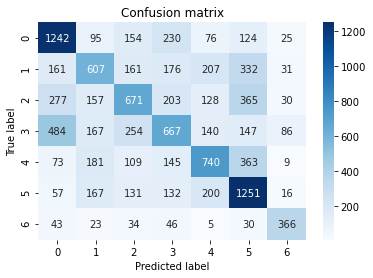

In [26]:
from sklearn.metrics import confusion_matrix
cm2_train = confusion_matrix(y_train, y_pred_train)
cm2_test = confusion_matrix(y_test, y_pred_test)

#Graficar la matriz de confusión.
import seaborn as sns
sns.heatmap(cm2_train, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()  

In [27]:
report_test2 = classification_report(y_test ,y_pred_test.round())  
print(report_test2)

report_train2 = classification_report(y_train ,y_pred_train.round())  
print(report_train2)

              precision    recall  f1-score   support

           0       0.52      0.60      0.56       221
           1       0.33      0.32      0.32       188
           2       0.46      0.36      0.40       216
           3       0.40      0.30      0.34       222
           4       0.47      0.46      0.47       175
           5       0.43      0.58      0.49       213
           6       0.60      0.67      0.63        45

    accuracy                           0.45      1280
   macro avg       0.46      0.47      0.46      1280
weighted avg       0.44      0.45      0.44      1280

              precision    recall  f1-score   support

           0       0.53      0.64      0.58      1946
           1       0.43      0.36      0.40      1675
           2       0.44      0.37      0.40      1831
           3       0.42      0.34      0.38      1945
           4       0.49      0.46      0.47      1620
           5       0.48      0.64      0.55      1954
           6       0.65 

In [28]:
import pickle
pickle.dump(logistic_model_LR, open('models/LogisticRegression.model','wb'))